# Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import prince

import trimap

We can split the data into input variables `X` and our output variable `y`. I'm taking the first 4 months of the data in case there is significant time drift.

In [2]:
base_df = pd.read_csv('../data/Base.csv')

target = 'fraud_bool'
X = base_df.drop(target, axis = 1)
y = base_df[target]

# First n months of the data
X_train = X[X['month'] < 1]
y_train = y[X['month'] < 1]
X_train.shape

(132440, 31)

# Clean data

`intended_balcon_amount` is the only variable for which any negative value indicates missingness, rather than -1 indicating missingness. We will replace all negative values with -1 for this variable for consistency.

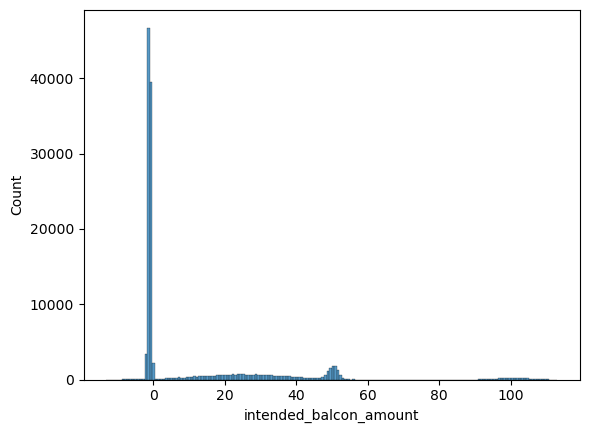

In [3]:
# Histogram of intended_balcon_amount
sns.histplot(data = X_train,
             x = 'intended_balcon_amount')

# Replace all negative intended_balcon_amount values with -1
X_train.loc[X_train['intended_balcon_amount'] < 0, 'intended_balcon_amount'] = -1

# EDA

## Variables by type

Categorical input variables:

- `payment_type`: 5 values `['AA', 'AD', 'AB', 'AC', 'AE']`
- `employment_status`: 7 values `['CB', 'CA', 'CC', 'CF', 'CD', 'CE', 'CG']`
- `housing_status`: 7 values `['BC', 'BE', 'BD', 'BA', 'BB', 'BF', 'BG']`
- `source`: 2 values `['INTERNET', 'TELEAPP']`
- `device_os`: 5 values `['linux', 'other', 'windows', 'x11', 'macintosh']`

Binary input variables:

- `email_is_free`
- `phone_home_valid`
- `phone_mobile_valid`
- `has_other_cards`
- `foreign_request`
- `keep_alive_session`

Binned numeric variables:

- `income`: binned to the nearest decile, e.g. 0.1, 0.2, ..., 0.9
- `customer_age`: binned to the nearest decade, e.g. 10, 20, ..., 90
- `proposed_credit_limit`: looks like it might be rounded to the nearest 10

Continuous numeric variables:

- `device_fraud_count` is always 0, so we should drop it


In [4]:
# Numerical (continuous/discrete) and categorical features

num_feats = X.select_dtypes(include='number').columns.tolist()

thresh = 10 # lowered threshold compared to notebook to make proposed_credit_limit continuous

cont_feats = [feat for feat in num_feats if base_df[feat].nunique() >= thresh]
bool_feats = [feat for feat in num_feats if base_df[feat].nunique() == 2]
disc_feats = [feat for feat in num_feats if base_df[feat].nunique() < thresh and feat not in bool_feats]

cat_feats = X.select_dtypes(exclude='number').columns.tolist()

print(f'Features: {X.shape[1]}\n\n\
Continuous: {len(cont_feats)}\n\
{cont_feats}\n\n\
Boolean: {len(bool_feats)}\n\
{bool_feats}\n\n\
Discrete or Binned: {len(disc_feats)}\n\
{disc_feats}\n\n\
Categorical: {len(cat_feats)}\n\
{cat_feats}')

Features: 31

Continuous: 15
['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']

Boolean: 6
['email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session']

Discrete or Binned: 5
['income', 'customer_age', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Categorical: 5
['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


## Missingness:

-1 indicates missing value in:

- `prev_address_months_count`
- `current_address_months_count`
- `bank_months_count`
- `session_length_in_minutes`
- `device_distinct_emails_8w`

Any negative represents a missing value in `intended_balcon_amount`.



# PCA

We start by performing PCA on the first 4 months of the data using the continuous numeric variables only.

In [5]:
# Extract continuous numeric variables
# Scale them
X_num_cont = X_train[cont_feats]
print(X_num_cont.columns)
scaler = StandardScaler()
X_num_cont = scaler.fit_transform(X_num_cont)

# PCA
pca_num_cont = PCA(n_components = 2)
pca_num_cont.fit(X_num_cont)
print(pca_num_cont.explained_variance_ratio_)

Index(['name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes'],
      dtype='object')
[0.11690946 0.09662932]


Text(0, 0.5, 'PC2')

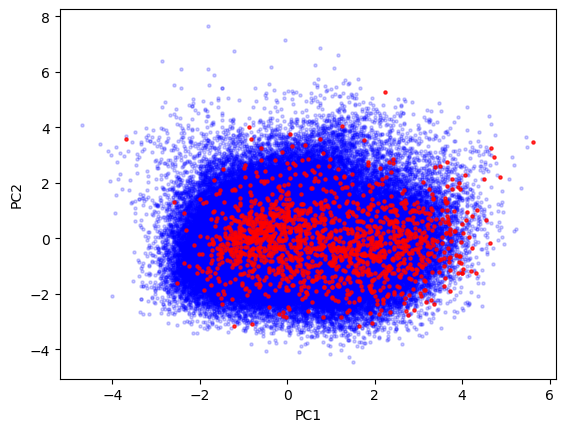

In [6]:
# Plot PCA
X_num_cont_pca = pca_num_cont.transform(X_num_cont)
plt.scatter(X_num_cont_pca[y_train == False, 0],
            X_num_cont_pca[y_train == False, 1],
            c = "blue",
            s = 5,
            alpha = 0.2)
plt.scatter(X_num_cont_pca[y_train == True, 0],
            X_num_cont_pca[y_train == True, 1],
            c = "red",
            s = 5,
            alpha = 0.8)

# Get the loadings
loadings_num_cont = pca_num_cont.components_
# print(loadings_num_cont)

# Plot the loadings
# for i, (comp1, comp2) in enumerate(zip(loadings_num_cont[0], loadings_num_cont[1])):
#     plt.arrow(0, 0, comp1, comp2, color = 'r', alpha = 0.5)
#     if cont_feats is not None:
#         plt.text(comp1, comp2, cont_feats[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel('PC1')
plt.ylabel('PC2')

Let's try adding the binned variables 'income', 'customer_age', and 'device_distinct_emails_8w' (treating them as if they are continous since at least they are numeric).

In [7]:
# Extract continuous numeric variables
# Scale them
X_num_cont_bin = X_train[cont_feats + ['income', 'customer_age', 'device_distinct_emails_8w']]
print(X_num_cont_bin.columns)
X_num_cont_bin = scaler.fit_transform(X_num_cont_bin)
print(X_num_cont_bin.shape)

# PCA
pca_num_cont_bin = PCA(n_components = 2)
pca_num_cont_bin.fit(X_num_cont_bin)
print(pca_num_cont_bin.explained_variance_ratio_)

Index(['name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'income', 'customer_age',
       'device_distinct_emails_8w'],
      dtype='object')
(132440, 18)
[0.10927374 0.08100598]


Text(0, 0.5, 'PC2')

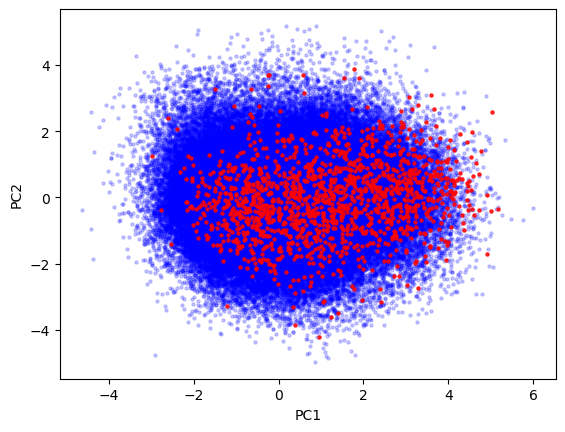

In [8]:
# Plot PCA
X_num_cont_bin_pca = pca_num_cont_bin.transform(X_num_cont_bin)
plt.scatter(X_num_cont_bin_pca[y_train == False, 0],
            X_num_cont_bin_pca[y_train == False, 1],
            c = "blue",
            s = 5,
            alpha = 0.2)
plt.scatter(X_num_cont_bin_pca[y_train == True, 0],
            X_num_cont_bin_pca[y_train == True, 1],
            c = "red",
            s = 5,
            alpha = 0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'Explained variance')

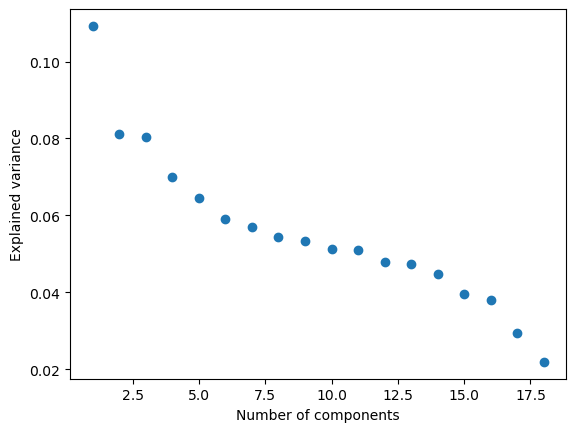

In [9]:
# Elbow plot for number of principle components
pca_num_cont_bin = PCA()
pca_num_cont_bin.fit(X_num_cont_bin)

plt.scatter(x = range(1, len(pca_num_cont_bin.explained_variance_ratio_) + 1),
                        y = pca_num_cont_bin.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

Fraudulent observations aren't outliers on either PCA :( Some potential issues to address:

- Address missingness: `intended_balcon_amount` and `prev_address_months_count` are missing in 70%+ of the total cases, and `bank_months_count` is missing in 25% of total cases, so probably should either exclude or impute these. Missingness might also be predictive of fraud vs. not fraud, but I don't think we can do PCA on an indicator variable?
- Binary / categorical variables: I don't think PCA on one-hot encoded variables works, maybe we can try FAMD to deal with these? Not sure how to plug FAMD into TriMap
- Number of PCs: Two principle components isn't explaining much of the variance, maybe more would help?

# TriMap

What happens if we try the default implementation of TriMap on our data?

In [10]:
# TriMap for continous variables + income + customer_age + device_distinct_emails_8w
X_num_cont_bin_trimap = trimap.TRIMAP().fit_transform(X_num_cont_bin)

Text(0, 0.5, 'TriMap2')

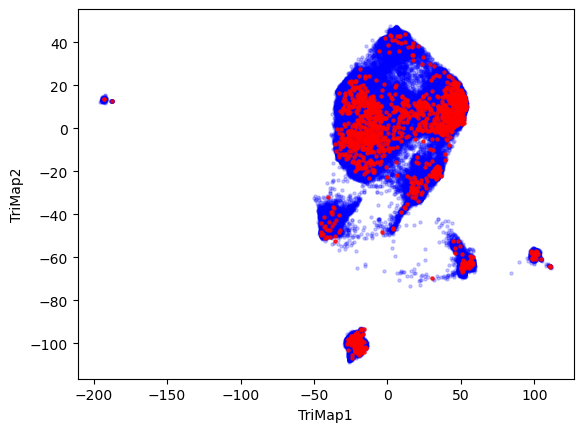

In [11]:
# Plot TriMap
plt.scatter(X_num_cont_bin_trimap[y_train == False, 0],
            X_num_cont_bin_trimap[y_train == False, 1],
            c = "blue",
            s = 5,
            alpha = 0.2)
plt.scatter(X_num_cont_bin_trimap[y_train == True, 0],
            X_num_cont_bin_trimap[y_train == True, 1],
            c = "red",
            s = 5,
            alpha = 0.8)
plt.xlabel('TriMap1')
plt.ylabel('TriMap2')

Like the PCA, the fraudulent cases are actually contained within the larger cloud of non-fraudulent cases. Also, clusters of outliers in the TriMap aren't necessarily fraud. We probably still have the same issues of not dealing with missingness correctly, leaving out the binary / categorical variables, etc.

# Missingness

Some of the variables have significant amounts of missingness, which might be predictive of fraud or just generally messing up our embeddings. We can see the proportion of observations in our training set with missing values for each variable:

/tmp/ipykernel_92553/3536583061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_nan[cols_missing_neg1] = X_train_nan[cols_missing_neg1].replace(-1,np.nan)


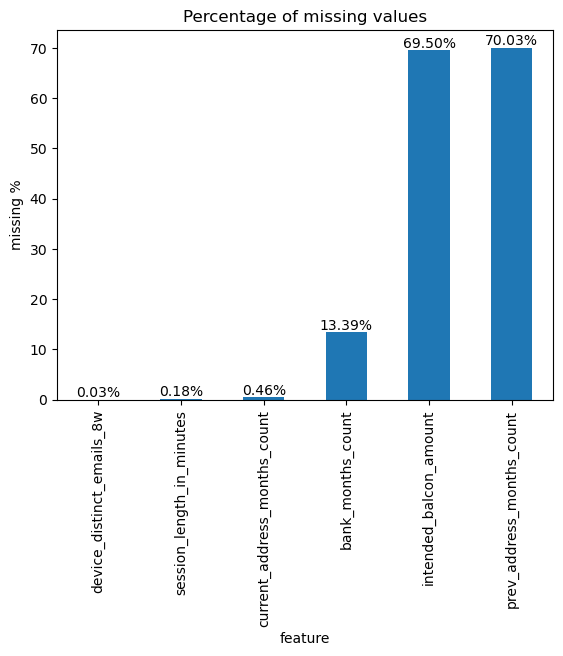

In [12]:
# Missing values
# The datasheet details how the missing values are represented

cols_missing_neg1 = ['prev_address_months_count',
                     'current_address_months_count',
                     'bank_months_count',
                     'session_length_in_minutes',
                     'device_distinct_emails_8w',
                     'intended_balcon_amount'] # already replaced all negative values with -1

X_train_nan = X_train
X_train_nan[cols_missing_neg1] = X_train_nan[cols_missing_neg1].replace(-1,np.nan)

# Missing values by feature
null_X_train = X_train_nan.isna().sum()/len(X_train_nan)*100

fig = plt.figure(figsize=(6.4,4.8))
ax = null_X_train.loc[null_X_train>0].sort_values()\
    .plot(kind='bar',title='Percentage of missing values')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

ax.set_ylabel('missing %')
ax.set_xlabel('feature')

ax.xaxis.grid(False)

plt.show()

`device_distinct_emails_8w`, `session_length_in_minutes`, and `current_address_months_count` have less than 1% missingness in our training set. We can drop rows where these features are missing, but it doesn't make much difference: (it also doesn't improve separation in the PCA to drop rows with missing `bank_months_count`)

[0.10962496 0.08130649]


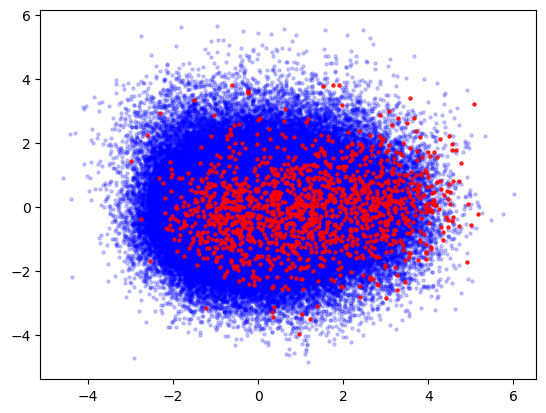

In [13]:
# Dropping rows missing values for features with < 1% missingness
missing_to_drop = ['device_distinct_emails_8w', 'session_length_in_minutes', 'current_address_months_count']
X_num_cont_bin_m = X_num_cont_bin[~X_train_nan[missing_to_drop].isna().any(axis=1)]
y_train_m = y_train[~X_train_nan[missing_to_drop].isna().any(axis=1)]

# PCA
pca_num_cont_bin_m = PCA(n_components = 2)
pca_num_cont_bin_m.fit(X_num_cont_bin_m)
print(pca_num_cont_bin_m.explained_variance_ratio_)
X_num_cont_bin_m_pca = pca_num_cont_bin_m.transform(X_num_cont_bin_m)
plt.scatter(X_num_cont_bin_m_pca[y_train_m == False, 0],
            X_num_cont_bin_m_pca[y_train_m == False, 1],
            c = "blue",
            s = 5,
            alpha = 0.2)
plt.scatter(X_num_cont_bin_m_pca[y_train_m == True, 0],
            X_num_cont_bin_m_pca[y_train_m == True, 1],
            c = "red",
            s = 5,
            alpha = 0.8)


Not really an improvement either.

# FAMD

Let's try FAMD to see if including the categorical variables helps make the fraudulent claims separate out. (Actually can't get FAMD to run on the training set without crashing)

In [14]:
# Get the variables we want for FAMD
# X_train_famd = X_train[cont_feats +
#                        ['income', 'customer_age', 'device_distinct_emails_8w', 'housing_status']]

# famd = prince.FAMD(
#     n_components=2,
#     n_iter=3,
#     copy=True,
#     check_input=True,
#     random_state=42,
#     engine="sklearn",
#     handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
# )
# famd = famd.fit(X_train_famd)
# famd.eigenvalues_summary

